In [ ]:
!pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"qasmovdyant","key":"4d4759066dca189587bcac8981b34740"}'}

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d sujaykapadnis/emotion-recognition-dataset

Dataset URL: https://www.kaggle.com/datasets/sujaykapadnis/emotion-recognition-dataset
License(s): CC-BY-NC-SA-4.0


In [ ]:
import zipfile
with zipfile.ZipFile('/content/emotion-recognition-dataset.zip') as zip_ref:
  zip_ref.extractall()

In [ ]:
import os

list(os.walk('/content/data.csv'))

[]

In [ ]:
!wget https://raw.githubusercontent.com/databyhuseyn/DeepLearning/refs/heads/main/helper_functions.py

--2025-04-16 07:30:40--  https://raw.githubusercontent.com/databyhuseyn/DeepLearning/refs/heads/main/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2025-04-16 07:30:41 (99.2 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
from helper_functions import walk_through_dir

In [ ]:
walk_through_dir('/content/data.csv')

In [ ]:
import pandas as pd

In [ ]:
emoji_df= pd.read_csv('/content/data.csv')

<Axes: xlabel='label'>

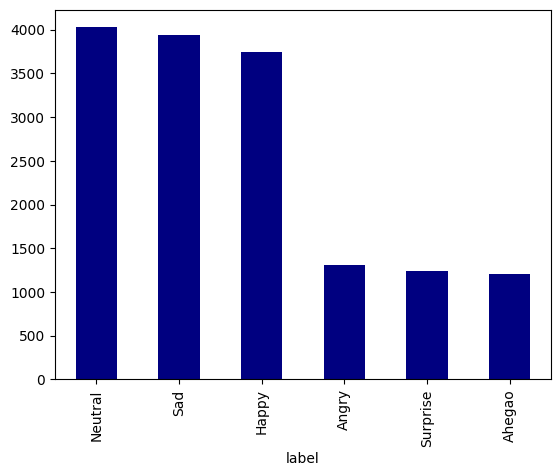

In [ ]:
emoji_df.groupby('label')['path'].count().sort_values(ascending=False).plot(kind='bar', cmap='jet')

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
# train_datagen= ImageDataGenerator(rescale = 1,/255,
#                                   horizontal = flip = True,
#                                   vertical_flip = True,
#                                   rotation_range = 0.2,
#                                   width_shift_range = 0.2,
#                                   height_shift_range = 0.2,
#                                   zoom_range = 0.2)

In [ ]:
train_dir = '/content/dataset'
IMG_SIZE = (224, 224)

In [ ]:
import tensorflow as tf

In [ ]:
import shutil
shutil.rmtree('/content/dataset/Ahegao')

In [ ]:
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    subset = 'training',
    label_mode = 'categorical',
    image_size = IMG_SIZE,
    crop_to_aspect_ratio = True,
    seed= 42,
    validation_split = 0.2
)
valid_data = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    subset = 'validation',
    label_mode = 'categorical',
    image_size = IMG_SIZE,
    crop_to_aspect_ratio = True,
    seed= 42,
    validation_split = 0.2
)

Found 14248 files belonging to 5 classes.
Using 11399 files for training.
Found 14248 files belonging to 5 classes.
Using 2849 files for validation.


In [ ]:
class_names = train_data.class_names
class_names

['Angry', 'Happy', 'Neutral', 'Sad', 'Surprise']

In [ ]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomHeight(0.2),
    tf.keras.layers.RandomWidth(0.2),
    tf.keras.layers.RandomContrast(0.2),
    tf.keras.layers.RandomZoom(0.2),

])

In [ ]:
inputs = tf.keras.layers.Input(shape = (224, 224, 3))
aug_data = data_augmentation(inputs)

In [ ]:
res = tf.keras.layers.Resizing(224, 2244)(aug_data)

In [ ]:
preprocess = tf.keras.applications.efficientnet_v2.preprocess_input(res)

In [ ]:
base_model = tf.keras.applications.EfficientNetV2B0(
    include_top = False,
    weights = 'imagenet',
    input_tensor = preprocess
)

24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [ ]:
base_model.trainable = True
for layer in base_model.layers[:100]:
  layer.trainable = False

In [ ]:
avg = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)

In [ ]:
dense = tf.keras.layers.Dense(128, activation = 'relu',
                              kernel_initializer = 'he_normal')(avg)

In [ ]:
dropout = tf.keras.layers.Dropout(0.5)(dense)

In [ ]:
output = tf.keras.layers.Dense(len(class_names), 'softmax' if len(class_names) > 2 else 'sigmoid')(dropout)

In [ ]:
model = tf.keras.Model(inputs, output, name = 'Emoji')

In [ ]:
model.summary()

Model: "Emoji"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, None,      │          0 │ input_layer[0][0] │
│ (Sequential)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resizing_1          │ (None, 224, 2244, │          0 │ sequential[0][0]  │
│ (Resizing)          │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 2244, │          0 │ resizing_1[0][0]  │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 2244, │          0 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 1122, │        864 │ normalization[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 1122, │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 1122, │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 1122, │      4,608 │ stem_activation[… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, 112, 1122, │         64 │ block1a_project_… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_ac… │ (None, 112, 1122, │          0 │ block1a_project_… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_conv │ (None, 56, 561,   │      9,216 │ block1a_project_… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_bn   │ (None, 56, 561,   │        256 │ block2a_expand_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_act… │ (None, 56, 561,   │          0 │ block2a_expand_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_project_co… │ (None, 56, 561,   │      2,048 │ block2a_expand_a… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_project_bn  │ (None, 56, 561,   │        128 │ block2a_project_… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_conv │ (None, 56, 561,   │     36,864 │ block2a_project_

 Total params: 6,083,925 (23.21 MB)

 Trainable params: 5,339,749 (20.37 MB)

 Non-trainable params: 744,176 (2.84 MB)

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss='categorical_crossentropy',
              optimizer = optimizer,
              metrics = ['accuracy'])

In [ ]:
model_ckp = tf.keras.callbacks.ModelCheckpoint(save_best_only = True,
                                               filepath = '/content/emoji.keras')
model_es = tf.keras.callbacks.EarlyStopping(restore_best_weights = True,
                                            patience = 5)

In [ ]:
history = model.fit(
    train_data,
    epochs=5,
    validation_data = valid_data,
    callbacks = [model_ckp, model_es]
)

Epoch 1/5
357/357 ━━━━━━━━━━━━━━━━━━━━ 461s 1s/step - accuracy: 0.7804 - loss: 0.5592 - val_accuracy: 0.7476 - val_loss: 0.6476
Epoch 2/5
357/357 ━━━━━━━━━━━━━━━━━━━━ 501s 1s/step - accuracy: 0.7780 - loss: 0.5718 - val_accuracy: 0.7543 - val_loss: 0.6678
Epoch 3/5
357/357 ━━━━━━━━━━━━━━━━━━━━ 461s 1s/step - accuracy: 0.7852 - loss: 0.5491 - val_accuracy: 0.7610 - val_loss: 0.6055
Epoch 4/5
357/357 ━━━━━━━━━━━━━━━━━━━━ 459s 1s/step - accuracy: 0.7871 - loss: 0.5348 - val_accuracy: 0.7571 - val_loss: 0.6627
Epoch 5/5
357/357 ━━━━━━━━━━━━━━━━━━━━ 460s 1s/step - accuracy: 0.7915 - loss: 0.5265 - val_accuracy: 0.7627 - val_loss: 0.6184


In [ ]:
model.save('/content/emotions_detect.keras')

In [ ]:
with zipfile('keras_emoji.zip') as zip_ref:
  zip_ref.write('/content/emoji.keras')

In [ ]:
import pathlib
import numpy as np
data_dir = pathlib.Path('/content/EmotionsDataset/data')
data_dir

PosixPath('/content/EmotionsDataset/data')

In [ ]:
class_names = np.array(sorted([item.name for item in data_dir.glob('*')]))
print(class_names)

[]


In [ ]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Qovluqların adlarını əldə edirik
class_names = os.listdir(data_dir)

# Train, test və validation üçün qovluqlar yaradılır
train_dir = "data/train"
test_dir = "data/test"
val_dir = "data/val"

# Train və test qovluqları yaradılır
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Train və test datasetlərinə şəkilləri ayıraq
for class_name in class_names:
    class_path = os.path.join(data_dir, class_name)

    # Sinifə aid bütün şəkillərin siyahısını əldə edirik
    all_files = os.listdir(class_path)

    # Train və test üçün 80% və 20% ayırırıq
    train_files, test_files = train_test_split(all_files, test_size=0.2, random_state=42)

    # Train və test qovluqlarını yaratmaq
    train_class_dir = os.path.join(train_dir, class_name)
    test_class_dir = os.path.join(test_dir, class_name)
    os.makedirs(train_class_dir, exist_ok=True)
    os.makedirs(test_class_dir, exist_ok=True)

    # Train və test şəkillərini qovluqlara köçürürük
    for file in train_files:
        shutil.copy(os.path.join(class_path, file), os.path.join(train_class_dir, file))

    for file in test_files:
        shutil.copy(os.path.join(class_path, file), os.path.join(test_class_dir, file))

# Train datasetindən validation ayıraq
os.makedirs(val_dir, exist_ok=True)

# Train datasetindən 20% validation ayırmaq
for class_name in class_names:
    train_class_dir = os.path.join(train_dir, class_name)

    # Train sinifinin şəkillərini alırıq
    train_files = os.listdir(train_class_dir)

    # Train və validation üçün 80% - 20% ayırırıq
    train_files, val_files = train_test_split(train_files, test_size=0.2, random_state=42)

    # Validation qovluğu yaratmaq
    val_class_dir = os.path.join(val_dir, class_name)
    os.makedirs(val_class_dir, exist_ok=True)

    # Validation şəkillərini validation qovluğuna köçürürük
    for file in val_files:
        shutil.copy(os.path.join(train_class_dir, file), os.path.join(val_class_dir, file))

print("Train, test və validation datasetləri yaradıldı.")


KeyboardInterrupt: 

In [ ]:
import tensorflow as tf

# Train, Validation və Test datasetlərini TensorFlow-da yükləyirik
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size=(224, 224),
    batch_size=32,
    label_mode='int'
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    val_dir,
    image_size=(224, 224),
    batch_size=32,
    label_mode='int'
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    image_size=(224, 224),
    batch_size=32,
    label_mode='int',
    shuffle=False  # Test datasetində shuffle lazım deyil
)

# Sinif adlarını görmək
class_names = train_ds.class_names
print("Siniflər:", class_names)


In [ ]:
import tensorflow as tf

# Datasetləri yükləyirik
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    'data/train',  # Train datasetinin yolu
    image_size=(224, 224),  # Şəkil ölçüləri
    batch_size=32,  # Batch ölçüsü
    label_mode='int'  # Etiketləri tam ədəd kimi qəbul edirik
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    'data/val',  # Validation datasetinin yolu
    image_size=(224, 224),
    batch_size=32,
    label_mode='int'
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    'data/test',  # Test datasetinin yolu
    image_size=(224, 224),
    batch_size=32,
    label_mode='int',
    shuffle=False  # Test datasetində şufl etmək lazım deyil
)


In [ ]:
from tensorflow.keras import layers, models
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=10,
                           kernel_size = (3, 3),
                           padding = 'valid',
                           kernel_initializer = 'he_normal',
                           activation='relu',
                           input_shape = (224, 224, 3)),
    tf.keras.layers.Conv2D(filters=10,
                           kernel_size = (3, 3),
                           padding = 'valid',
                           kernel_initializer = 'he_normal',
                           activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(filters=10,
                           kernel_size = (3, 3),
                           padding = 'valid',
                           kernel_initializer = 'he_normal',
                           activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size = (2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(7, activation = 'softmax')

])

# Modelin xülasəsi
model.summary()


In [ ]:
model.compile(
    optimizer='adam',  # Optimizasiya metodu
    loss='sparse_categorical_crossentropy',  # Sinifləndirmə itkisi funksiyası
    metrics=['accuracy']  # İzləyəcəyimiz metrikalar
)

In [ ]:
# Modelin təlimi
history = model.fit(
    train_ds,
    steps_per_epoch = len(train_ds),
    validation_data=val_ds,
    epochs=5
)


In [ ]:
plot_loss_curves(model)

In [ ]:
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

In [ ]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2)
])

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=3)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[early_stop]
)